In [1]:
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

In [21]:
batch_size = 64
learning_rate = 1e-4
epochs = 50

# Load data

In [13]:
df = pd.read_csv('data/annots.csv', converters={'coords': eval})

In [14]:
df.head()

,file_name,label,width,height,occculded,coords
0,data/archive/images/maksssksksss481.png,with_mask,400,267,0,"[13, 87, 35, 108]"
1,data/archive/images/maksssksksss481.png,with_mask,400,267,0,"[39, 92, 65, 118]"
2,data/archive/images/maksssksksss481.png,with_mask,400,267,0,"[98, 98, 117, 117]"
3,data/archive/images/maksssksksss481.png,with_mask,400,267,0,"[208, 67, 235, 97]"
4,data/archive/images/maksssksksss481.png,with_mask,400,267,0,"[160, 88, 172, 102]"


# Prepare data

In [16]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2021)

In [17]:
train_images_path = train_df['file_name'].values.tolist()
train_coords = train_df['coords'].values.tolist()

test_images_path = test_df['file_name'].values.tolist()
test_coords = test_df['coords'].values.tolist()

In [50]:
def convert_data(image_path, image_coords):
    image_buffer = tf.io.read_file(image_path)
    img = tf.io.decode_png(image_buffer, channels=3) # Remove alpha channel from png image
    img = tf.cast(img, tf.float32)
    img = img / 255.
    img = tf.image.resize(img, (224, 224))
    
    # Normalize coords
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    xmin = image_coords[0] / w
    ymin = image_coords[1] / h
    xmax = image_coords[2] / w
    ymax = image_coords[3] / h
    
    return img, tf.convert_to_tensor([xmin, ymin, xmax, ymax], dtype=tf.float32)

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_path, train_coords))
train_dataset = train_dataset.map(convert_data)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(len(train_images_path))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images_path, test_coords))
test_dataset = test_dataset.map(convert_data)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Build model

In [23]:
resnet = tf.keras.applications.resnet50.ResNet50(
    weights='imagenet', include_top=False,
    input_tensor=tf.keras.layers.Input(shape=(224, 224, 3))
)
resnet.trainable = False
embeddings = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)

# Fully connected layer
box_head = tf.keras.layers.Dense(512)(embeddings)
box_head = tf.keras.layers.Activation('relu')(box_head)
box_head = tf.keras.layers.Dense(256)(box_head)
box_head = tf.keras.layers.Activation('relu')(box_head)
box_head = tf.keras.layers.Dense(4)(box_head)
box_head = tf.keras.layers.Activation('sigmoid')(box_head)

model = tf.keras.Model(inputs=resnet.input, outputs=box_head)

In [24]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [25]:
model.compile(
    loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
)

In [26]:
history = model.fit(
    train_dataset, epochs=epochs, validation_data=test_dataset
)

Epoch 1/50
51/51 [==============================] - 18s 359ms/step - loss: 0.1581 - val_loss: 0.1408
Epoch 2/50
51/51 [==============================] - 9s 172ms/step - loss: 0.1416 - val_loss: 0.1385
Epoch 3/50
51/51 [==============================] - 9s 174ms/step - loss: 0.1392 - val_loss: 0.1373
Epoch 4/50
51/51 [==============================] - 9s 174ms/step - loss: 0.1377 - val_loss: 0.1360
Epoch 5/50
51/51 [==============================] - 9s 174ms/step - loss: 0.1365 - val_loss: 0.1348
Epoch 6/50
51/51 [==============================] - 9s 173ms/step - loss: 0.1355 - val_loss: 0.1338
Epoch 7/50
51/51 [==============================] - 9s 172ms/step - loss: 0.1347 - val_loss: 0.1329
Epoch 8/50
51/51 [==============================] - 9s 170ms/step - loss: 0.1340 - val_loss: 0.1322
Epoch 9/50
51/51 [==============================] - 9s 170ms/step - loss: 0.1335 - val_loss: 0.1315
Epoch 10/50
51/51 [==============================] - 9s 170ms/step - loss: 0.1330 - val_loss: 0.131

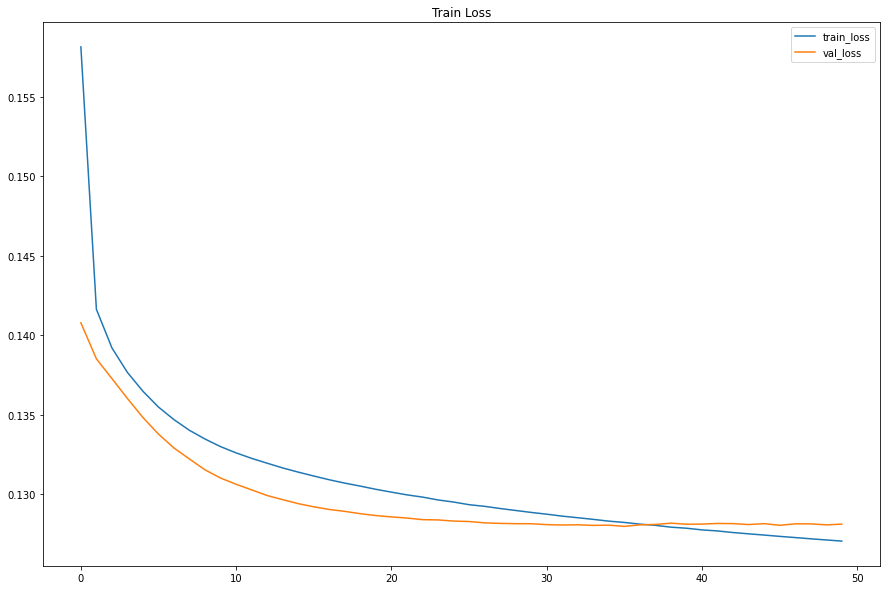

In [27]:
plt.figure(figsize=(15, 10))
plt.title('Train Loss')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()

# Evaluate model

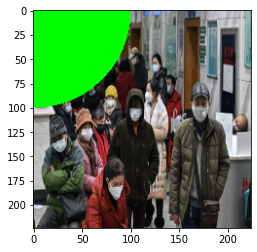

In [54]:
img_byte = tf.io.read_file(test_df.iloc[0]['file_name'])
img = tf.io.decode_png(img_byte, channels=3)
img_resize = tf.image.resize(img, (224, 224))
img_resize = img_resize / 255.
img_input = tf.expand_dims(img_resize, axis=0)

xmin, ymin, xmax, ymax = model.predict(img_input)[0].astype(np.int)
xmin = xmin * 224
ymin = ymin * 224
xmax = xmax * 224
ymax = ymax * 224

img = img.numpy()
img = cv2.resize(img, (224, 224))
cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 200)
plt.imshow(img)